# Training a CNN model on CIFAR10

### Install dependencies

In [8]:
%pip install matplotlib seaborn torch torchvision torchaudio numpy

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Dependencies
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # this import just makes the plots prettier
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Select device

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Data
Collect the CIFAR10 dataset

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

train_set = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


Show example images from the dataset

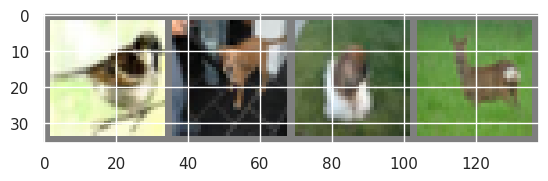

bird  dog   dog   deer 


In [13]:

def imshow(img):
    # Unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Create a classifier model

In [35]:
class Cifar10Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.body = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=6,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(
                in_channels=6,
                out_channels=16,
                kernel_size=5,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(16 * 6 * 6, 120),
            torch.nn.ReLU(),
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(),
            torch.nn.Linear(84, 10),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        output = self.body(x)
        return output

In [46]:
model = Cifar10Classifier()
model.to(device)

Cifar10Classifier(
  (body): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=576, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
    (12): ReLU()
  )
)

Create a loss function and an optimizer

In [47]:
learning_rate = 0.001

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train the model

In [48]:
def train(num_epochs):

    model.train()

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        # For each batch in the training data
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)

            # Compute output and loss
            output = model(images)
            loss = loss_func(output, labels)

            # Clear gradients for this training step
            optimizer.zero_grad()

            # Compute gradients
            loss.backward()
            # Apply gradients
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )

    print("Done.")


train(2)

/home/io/miniconda3/envs/diip/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/io/miniconda3/envs/diip/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/2], Step [100/12500], Loss: 2.3244
Epoch [1/2], Step [200/12500], Loss: 2.4876
Epoch [1/2], Step [300/12500], Loss: 2.1205
Epoch [1/2], Step [400/12500], Loss: 1.6693
Epoch [1/2], Step [500/12500], Loss: 2.2079
Epoch [1/2], Step [600/12500], Loss: 2.2760
Epoch [1/2], Step [700/12500], Loss: 1.5788
Epoch [1/2], Step [800/12500], Loss: 2.3035
Epoch [1/2], Step [900/12500], Loss: 2.0136
Epoch [1/2], Step [1000/12500], Loss: 1.6311
Epoch [1/2], Step [1100/12500], Loss: 2.1624
Epoch [1/2], Step [1200/12500], Loss: 2.1017
Epoch [1/2], Step [1300/12500], Loss: 2.0545
Epoch [1/2], Step [1400/12500], Loss: 1.7558
Epoch [1/2], Step [1500/12500], Loss: 2.0219
Epoch [1/2], Step [1600/12500], Loss: 2.0952
Epoch [1/2], Step [1700/12500], Loss: 2.4017
Epoch [1/2], Step [1800/12500], Loss: 2.0827
Epoch [1/2], Step [1900/12500], Loss: 2.3183
Epoch [1/2], Step [2000/12500], Loss: 2.3130
Epoch [1/2], Step [2100/12500], Loss: 2.1494
Epoch [1/2], Step [2200/12500], Loss: 2.1336
Epoch [1/2], Step [

Now test the trained model

In [51]:
def test():
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)

            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)
        
        accuracy = correct / float(total)
        print('Test Accuracy of the model: %.2f%%' % (accuracy * 100))
test()

Test Accuracy of the model: 36.89%


Now, let us train more and see how the result changes

In [52]:
train(4)

Epoch [1/4], Step [100/12500], Loss: 2.4426
Epoch [1/4], Step [200/12500], Loss: 1.6469
Epoch [1/4], Step [300/12500], Loss: 1.9028
Epoch [1/4], Step [400/12500], Loss: 0.8953
Epoch [1/4], Step [500/12500], Loss: 1.6668
Epoch [1/4], Step [600/12500], Loss: 1.5551
Epoch [1/4], Step [700/12500], Loss: 0.7653
Epoch [1/4], Step [800/12500], Loss: 2.8405
Epoch [1/4], Step [900/12500], Loss: 2.4236
Epoch [1/4], Step [1000/12500], Loss: 1.8627
Epoch [1/4], Step [1100/12500], Loss: 2.0986
Epoch [1/4], Step [1200/12500], Loss: 2.0645
Epoch [1/4], Step [1300/12500], Loss: 1.2067
Epoch [1/4], Step [1400/12500], Loss: 2.2337
Epoch [1/4], Step [1500/12500], Loss: 1.8261
Epoch [1/4], Step [1600/12500], Loss: 1.4659
Epoch [1/4], Step [1700/12500], Loss: 1.7158
Epoch [1/4], Step [1800/12500], Loss: 1.4601
Epoch [1/4], Step [1900/12500], Loss: 1.7504
Epoch [1/4], Step [2000/12500], Loss: 1.5606
Epoch [1/4], Step [2100/12500], Loss: 1.9555
Epoch [1/4], Step [2200/12500], Loss: 1.3925
Epoch [1/4], Step [

In [53]:
test()

Test Accuracy of the model: 42.27%
